---
# **Feature Detectors: Harris, FAST, and ORB**
---

## **1. Harris Corner Detector**


##**Intuition**
Corners are locations where intensity changes **in both x and y directions**.  
Edges change in one direction only; flat regions barely change at all.

### **Step-by-step**

1. **Compute image gradients:**
   - \( I_x \) = gradient in x  
   - \( I_y \) = gradient in y  

2. Form the **structure tensor** (also called second moment matrix):

\[
M =
\begin{bmatrix}
\sum I_x^2 & \sum I_x I_y \\
\sum I_x I_y & \sum I_y^2
\end{bmatrix}
\]

3. **Compute Harris response:**

\[
  R = (A · C - B^2) - k · (A + C)^2
  \]


**Interpretation:**
- Large positive R → strong corner  
- Negative R → edge  
- Small R → flat area

**Key parameters:**
- **blockSize**: neighborhood size  
- **ksize**: Sobel kernel size  
- **k**: sensitivity constant (0.04–0.06 standard)

---

## **2. FAST**

FAST = **Features from Accelerated Segment Test**.  
Designed purely for speed — often used in SLAM, AR/VR, robotics.


### **Intuition**
For a pixel \( p \):
- Look at **16 pixels around it** (Bresenham circle)
- If **N contiguous pixels** are:
  - All brighter than \( p + t \), OR  
  - All darker than \( p - t \)  
→ p is a corner.

No gradients, no heavy math → extremely fast.

### **Limitations**
- Not scale invariant  
- Not rotation invariant (unless extended variants used)

---

# **3. ORB**

ORB = **Oriented FAST + Rotated BRIEF**

### **Composition**
1. **FAST** (for keypoint detection)  
2. **Orientation assignment** using intensity centroid → gives rotation invariance  
3. **BRIEF-like binary descriptor**  
4. Multi-scale pyramid → scale awareness  
5. Binary descriptors → blazing-fast matching using Hamming

### **Strengths**
- Free & open source alternative to SIFT/SURF  
- Excellent accuracy-speed tradeoff  
- Great for feature matching (tracking, SLAM, stitching)

---

# Summary Table

| Detector | Type | Pros | Cons |
|---------|------|------|------|
| Harris | Corner response | Accurate corners | No descriptors |
| FAST | Keypoint detector | Very fast | No scale/rotation |
| ORB | Detector + Descriptor | Fast + robust + matchable | Less accurate than SIFT |

---

---

# **PRACTICAL IMPLEMENTATION**

---

This cell imports the required libraries, configures plotting defaults, and defines a helper function to display images cleanly inside the notebook.

In [7]:
# Cell 1: Setup
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,6)

def show(img, title=None):
    if len(img.shape) == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    if title: plt.title(title)
    plt.show()

This cell loads the input image, converts it to grayscale for processing, and displays the original image.

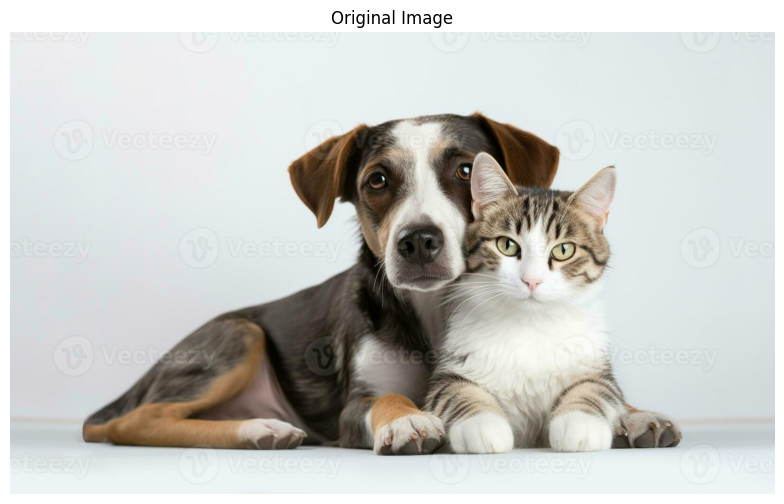

In [8]:
# Cell 2: Load Image
img_path = "/content/sample.jpg"
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

show(img, "Original Image")

---

## **HARRIS CORNER DETECTOR**

This cell computes Harris corner responses, marks the strongest corners in red, and displays the result.

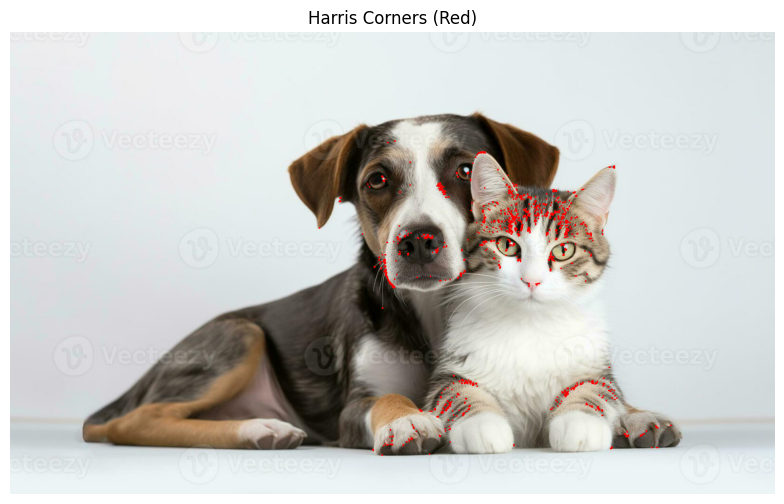

In [9]:
# Harris Implementation
gray_f = np.float32(gray)
dst = cv2.cornerHarris(gray_f, blockSize=2, ksize=3, k=0.04)
dst = cv2.dilate(dst, None)

overlay = img.copy()
overlay[dst > 0.01 * dst.max()] = [0, 0, 255]

show(overlay, "Harris Corners (Red)")

---

## **FAST KEYPOINT DETECTOR**

This cell detects FAST keypoints in the image and visualizes them in green.

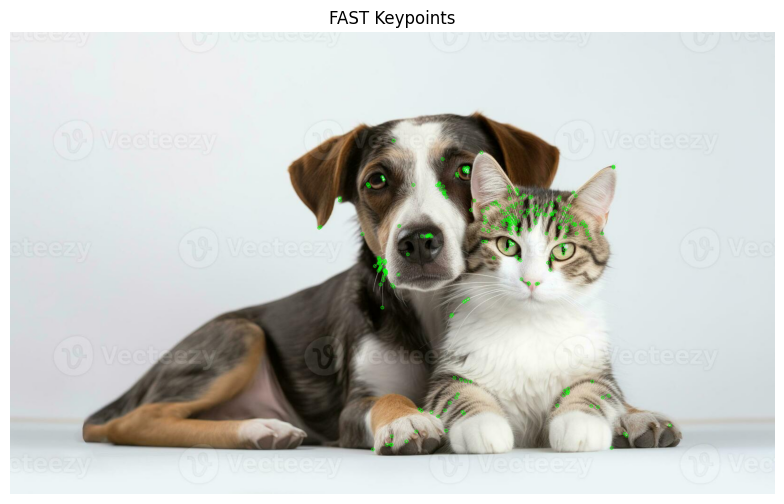

In [10]:
# FAST Implementation
fast = cv2.FastFeatureDetector_create(
    threshold=50,
    nonmaxSuppression=True,
    type=cv2.FAST_FEATURE_DETECTOR_TYPE_9_16
)

kp_fast = fast.detect(gray, None)

img_fast = cv2.drawKeypoints(img, kp_fast, None, color=(0,255,0))
show(img_fast, "FAST Keypoints")

---

## **ORB DETECTOR + DESCRIPTOR**

This cell detects ORB keypoints, computes their descriptors, visualizes them in red, and prints the descriptor size.

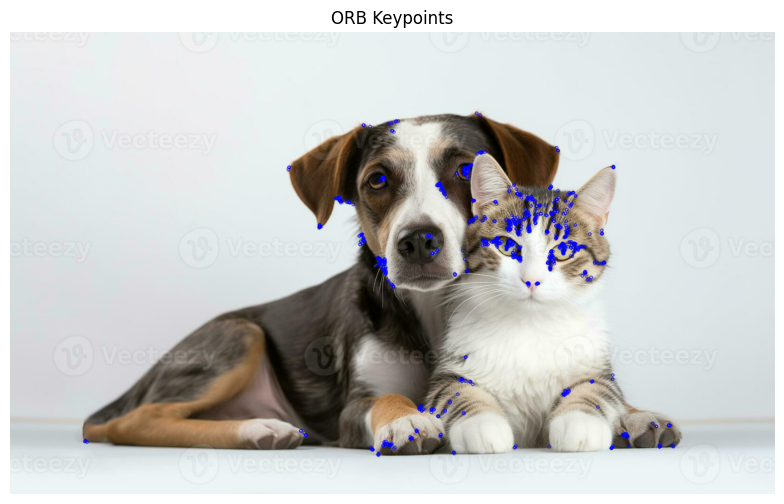

Descriptor Shape: (1000, 32)


In [11]:
# ORB Implementation
orb = cv2.ORB_create(nfeatures=1000)
kp_orb, des_orb = orb.detectAndCompute(gray, None)

img_orb = cv2.drawKeypoints(img, kp_orb, None, color=(255,0,0), flags=2)
show(img_orb, "ORB Keypoints")
print("Descriptor Shape:", des_orb.shape)

---

## **ORB MATCHING DEMO**

This cell creates a rotated version of the image, extracts ORB features from both images, matches them using Hamming distance, and visualizes the top matches.

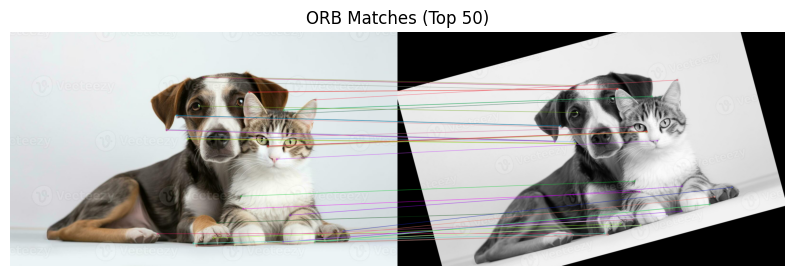

In [12]:
# Create a rotated version for matching
rows, cols = gray.shape
M = cv2.getRotationMatrix2D((cols//2, rows//2), 15, 0.9)
gray2 = cv2.warpAffine(gray, M, (cols, rows))

kp2, des2 = orb.detectAndCompute(gray2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des_orb, des2)
matches = sorted(matches, key=lambda x: x.distance)

matched = cv2.drawMatches(img, kp_orb, cv2.cvtColor(gray2, cv2.COLOR_GRAY2BGR),
                          kp2, matches[:50], None, flags=2)

show(matched, "ORB Matches (Top 50)")

---

# **INBUILT FUNCTION SYNTAX REFERENCE**
---
## **cv2.cornerHarris()**
cv2.cornerHarris(src, blockSize, ksize, k)

## **cv2.FastFeatureDetector_create()**
fast = cv2.FastFeatureDetector_create(
    threshold=50,
    nonmaxSuppression=True,
    type=cv2.FAST_FEATURE_DETECTOR_TYPE_9_16
)
fast.detect(image, None)

## **cv2.ORB_create()**
orb = cv2.ORB_create(
    nfeatures=500,
    scaleFactor=1.2,
    nlevels=8,
    edgeThreshold=31,
    patchSize=31
)
keypoints, descriptors = orb.detectAndCompute(image, None)

## **cv2.BFMatcher()**
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

---